<a href="https://colab.research.google.com/github/Abdulbarikassim/FaceEmotionDetection/blob/main/custom_CovNet_fer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

abdulbarikassim_fer_2013_ck_dataset_path = kagglehub.dataset_download('abdulbarikassim/fer-2013-ck-dataset')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer-2013-ck-dataset/ckextended.csv
/kaggle/input/fer-2013-ck-dataset/fer2013.csv


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models,regularizers
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


In [ ]:


def preprocess_image(image):
    image = np.array(image, dtype=np.uint8).reshape(48, 48, 1)
    image = image / 255.0
    return image

def load_fer2013(csv_path, sample_size=5000):
    data = pd.read_csv(csv_path)
    data = data[:sample_size]
    images = np.array([np.fromstring(pixels, dtype=np.uint8, sep=' ') for pixels in data['pixels']])
    images = np.array([preprocess_image(img) for img in images])
    labels = data['emotion'].values
    return train_test_split(images, labels, test_size=0.2, random_state=42)

def build_convnet(input_shape=(48, 48, 1), num_classes=7):
    model = models.Sequential()

    # First Convolutional Layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    # Second Convolutional Layer
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    # Third Convolutional Layer
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    # Fourth Convolutional Layer
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    # Flattening Layer
    model.add(layers.Flatten())

    # Fully Connected Layers
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Compile the model
def compile_model(model):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00095),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Load dataset
csv_path = '/kaggle/input/fer-2013-ck-dataset/fer2013.csv'  # Change this path accordingly
X_train, X_test, y_train, y_test = load_fer2013(csv_path)

# Convert to NumPy arrays
X_train = np.array(X_train).reshape(-1, 48, 48, 1)
X_test = np.array(X_test).reshape(-1, 48, 48, 1)

y_train = np.array(y_train)
y_test = np.array(y_test)

# Create and compile the ConvNet model
convnet = build_convnet()
convnet = compile_model(convnet)

# Train the model with more epochs and augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

datagen.fit(X_train)

convnet.fit(datagen.flow(X_train, y_train, batch_size=32),
            epochs=30,
            validation_data=(X_test, y_test))

# Display model summary
convnet.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 462ms/step - accuracy: 0.1525 - loss: 4.8990 - val_accuracy: 0.1760 - val_loss: 4.6887
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 55s 442ms/step - accuracy: 0.1914 - loss: 4.3811 - val_accuracy: 0.1830 - val_loss: 4.3551
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 447ms/step - accuracy: 0.2220 - loss: 4.0832 - val_accuracy: 0.2710 - val_loss: 3.7944
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 447ms/step - accuracy: 0.2205 - loss: 3.8983 - val_accuracy: 0.2780 - val_loss: 3.6101
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - accuracy: 0.2191 - loss: 3.7257 - val_accuracy: 0.2340 - val_loss: 3.5659
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 464ms/step - accuracy: 0.2514 - loss: 3.5039 - val_accuracy: 0.2800 - val_loss: 3.2953
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 462ms/step - accuracy: 0.2553 - loss: 3.3459 - val_accuracy: 0.2990 - val_loss: 3.1861
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 479ms/step - accuracy: 0.3059 - loss: 3.1853 - val

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 12,142,103 (46.32 MB)

 Trainable params: 4,046,215 (15.44 MB)

 Non-trainable params: 3,456 (13.50 KB)

 Optimizer params: 8,092,432 (30.87 MB)

In [ ]:
# save the model

convnet.save("fer2013_model.h5")

In [ ]:
# Fine-tuning method
def fine_tune_model(model, new_learning_rate=0.00095):
    model.trainable = True
    for layer in model.layers[:-5]:
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=new_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Load and train on CK+ dataset
def load_ck_dataset(csv_path):
    data = pd.read_csv(csv_path)
    images = np.array([np.fromstring(pixels, dtype=np.uint8, sep=' ') for pixels in data['pixels']])
    images = np.array([preprocess_image(img) for img in images])
    labels = data['emotion'].values

    # Remove samples where label == 7
    valid_indices = labels < 7
    images = images[valid_indices]
    labels = labels[valid_indices]

    return train_test_split(images, labels, test_size=0.2, random_state=42)

# Set correct path for CK+ dataset
ck_csv_path = '/kaggle/input/fer-2013-ck-dataset/ckextended.csv'
X_train_ck, X_test_ck, y_train_ck, y_test_ck = load_ck_dataset(ck_csv_path)

# Convert to NumPy arrays
X_train_ck = np.array(X_train_ck).reshape(-1, 48, 48, 1)
X_test_ck = np.array(X_test_ck).reshape(-1, 48, 48, 1)

y_train_ck = np.array(y_train_ck)
y_test_ck = np.array(y_test_ck)

# Fine-tune the model
convnet = fine_tune_model(convnet)

# Train on CK+ dataset
convnet.fit(datagen.flow(X_train_ck, y_train_ck, batch_size=32),
            epochs=30,
            validation_data=(X_test_ck, y_test_ck))

Epoch 1/30
 1/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7812 - loss: 0.7594

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.8393 - loss: 0.6188 - val_accuracy: 0.8343 - val_loss: 0.6249
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.7974 - loss: 0.6800 - val_accuracy: 0.8453 - val_loss: 0.5760
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.8473 - loss: 0.6287 - val_accuracy: 0.8453 - val_loss: 0.5952
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.8083 - loss: 0.6793 - val_accuracy: 0.8343 - val_loss: 0.6311
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.8048 - loss: 0.6869 - val_accuracy: 0.8343 - val_loss: 0.6075
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.8646 - loss: 0.5688 - val_accuracy: 0.8398 - val_loss: 0.5799
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.8497 - loss: 0.5745 - val_accuracy: 0.8453 - val_loss: 0.5639
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.8265 - loss: 0.6420 - val_accuracy: 0.8398 - val_

In [ ]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")
    return loss, accuracy

# Function to save the model
def save_model(model, save_path):
    model.save(save_path)
    print(f"Model saved to {save_path}")

# Example usage after fine-tuning
# Evaluate the model after fine-tuning
evaluate_model(convnet, X_test_ck, y_test_ck)

# Save the fine-tuned model
# save_path = '/kaggle/working/fine_tuned_model.h5'
save_path = '/kaggle/working/fine_tuned_model2_ck.h5'
save_model(convnet, save_path)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.7746 - loss: 1.9114
Test Loss: 1.8625, Test Accuracy: 79.56%
Model saved to /kaggle/working/fine_tuned_model2_ck.h5


In [ ]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")
    return loss, accuracy

# Function to save the model
def save_model(model, save_path):
    model.save(save_path)
    print(f"Model saved to {save_path}")

# Example usage after fine-tuning
# Evaluate the model after fine-tuning
evaluate_model(convnet, X_test, y_test)

# Save the fine-tuned model
# save_path = '/kaggle/working/fine_tuned_model.h5'
save_path = '/kaggle/working/fine_tuned_model2_fer.h5'
save_model(convnet, save_path)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.4703 - loss: 2.2460
Test Loss: 2.2449, Test Accuracy: 47.00%
Model saved to /kaggle/working/fine_tuned_model2_fer.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
F1 Score ck dataset:  0.7945265199782283


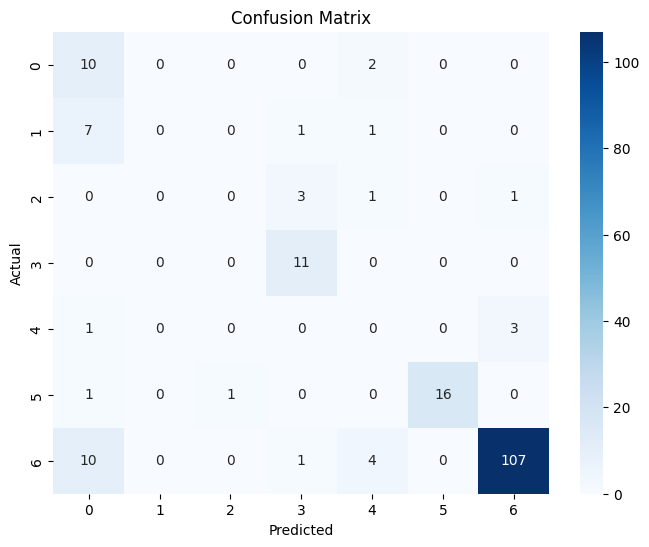

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

 # Make predictions on the test set
y_pred = convnet.predict(X_test_ck)

y_pred_classes = np.argmax(y_pred, axis=1)

 # Compute the F1 score
f1 = f1_score(y_test_ck, y_pred_classes, average='weighted')
print("F1 Score ck dataset: ", f1)

 # Generate the confusion matrix
cm = confusion_matrix(y_test_ck, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(7), yticklabels=np.arange(7))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

plt.savefig('/kaggle/working/confusion_matrix.png')

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
F1 Score for FER2013:  0.4677106424120345


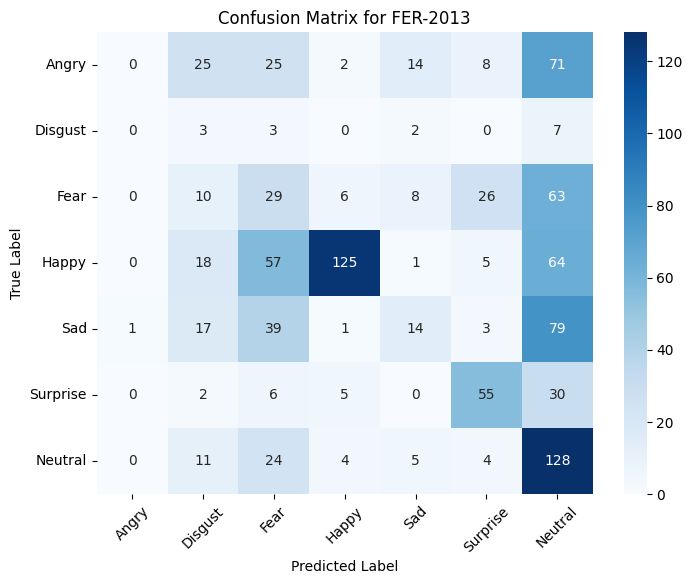

In [ ]:
# Define class labels for FER-2013 dataset
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

y_pred = convnet.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)

 # Compute the F1 score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print("F1 Score for FER2013: ", f1)
# Plotting the confusion matrix for FER-2013
plt.figure(figsize=(8, 6))
sns.heatmap(cm_fer, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for FER-2013')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.yticks(rotation=0)
plt.show()